# 2025-09-26 QR Stability

* Stability and ill conditioning

* Intro to performance modeling

* Clasical vs Modified Gram-Schmidt

* Right vs left-looking algorithms

In [1]:
using LinearAlgebra
using Plots
using Polynomials
default(lw=4, ms=5, legendfontsize=12, xtickfontsize=12, ytickfontsize=12)

# Here's our Vandermonde matrix again
function vander(x, k=nothing)
    if isnothing(k)
        k = length(x)
    end
    m = length(x)
    V = ones(m, k)
    for j in 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

vander (generic function with 2 methods)

## Gram-Schmidt orthogonalization

Suppose we're given some vectors and want to find an  orthogonal basis for their span.

$$ A = \begin{split} \Bigg[ a_1 \Bigg| a_2 \Bigg] = \Bigg[ q_1 \Bigg| q_2 \Bigg] \begin{bmatrix} r_{11} & r_{12} \\ 0 & r_{22} \end{bmatrix} \end{split} = Q R$$

## A naive Gram-Schmidt algorithm

In [2]:
# Let's form Q and R by making each column orthonormal to all previous columns
function gram_schmidt_naive(A)
    m, n = size(A)
    Q = zeros(m, n) # Orthonormal basis
    R = zeros(n, n) # Upper triangular
    for j in 1:n
        v = A[:, j] # current column to normalize
        for k in 1:j-1
            # We do a projection against the previous
            #  columns of Q. Why?
            r = Q[:, k]' * v 
            v -= Q[:, k] * r
            R[k, j] = r # What is this factor?
        end
        # normalize and store our final v
        R[j, j] = norm(v)
        Q[:, j] = v / R[j, j]
    end
    Q, R
end

gram_schmidt_naive (generic function with 1 method)

## A variant with more parallelism

$$ q_2 q_2^T \left( q_1 q_1^T v \right) = q_2 \left( q_2^T q_1 \right) q_1^T v = 0 $$

In [3]:
# Let's form Q and R by making each column orthonormal to all previous columns
function gram_schmidt_classical(A)
    m, n = size(A)
    # Same setup as our niave version
    Q = zeros(m, n)
    R = zeros(n, n)
    for j in 1:n
        v = A[: ,j]
        R[1:j-1, j] = Q[:, 1:j-1]' * v
        v -= Q[:, 1:j-1] * R[1:j-1, j]
        R[j, j] = norm(v)
        Q[:, j] = v / norm(v)
    end
    Q, R
end

gram_schmidt_classical (generic function with 1 method)

## Order of operations matters

$$ \begin{align}
 \left( I - q_2 q_2^T \right) \left( I - q_1 q_1^T \right) v 
  &= \left( I - q_1 q_1^T - q_2 q_2^T + q_2 q_2^T q_1 q_1^T \right) v \\
  &= \left( I - \Bigg[ q_1 \Bigg| q_2 \Bigg] \begin{bmatrix} q_1^T \\ q_2^T \end{bmatrix} \right) v \end{align} $$

is not exact in finite arithmetic.

We can project out the components of our vectors in the directions of each $q_i$.

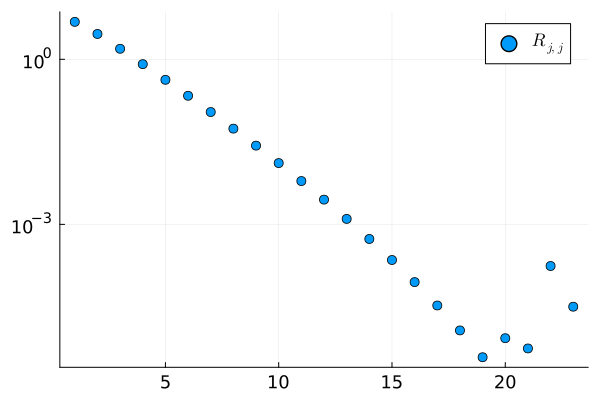

In [4]:
x = LinRange(-1, 1, 23)
A = vander(x)
# First with classical Gram-Schmidt
Q, R = gram_schmidt_classical(A)

scatter(diag(R), yscale=:log10, label="\$R_{j, j}\$")

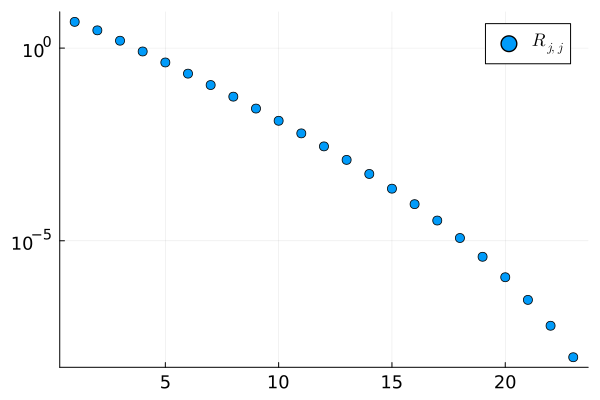

In [5]:
x = LinRange(-1, 1, 23)
A = vander(x)
# And also with 'naive'
Q, R = gram_schmidt_naive(A)

scatter(diag(R), yscale=:log10, label="\$R_{j, j}\$")

The final vector is almost linearly dependent.

norm(v) = 1.0


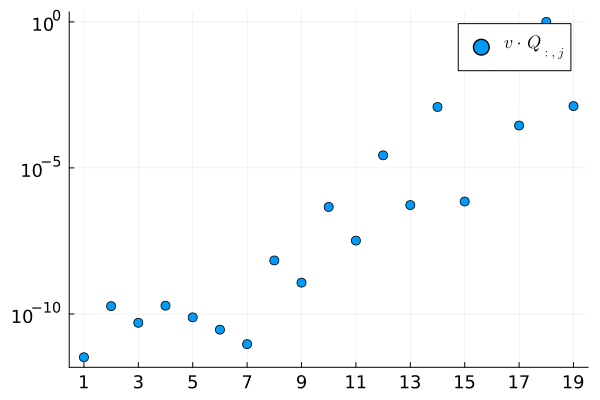

In [6]:
a = 20
x = LinRange(-1, 1, a)
A = vander(x)
Q, _ = gram_schmidt_classical(A)

v = Q[:, end]
@show norm(v)
# Note, if v is actually orthogonal, these should be 0
scatter(abs.(Q[:, 1:end-1]' * v), yscale=:log10, xticks=range(1, a-1; step=2), label="\$v \\cdot Q_{:, j}\$")

Let's compare with our naive implemenation.

norm(v) = 1.0


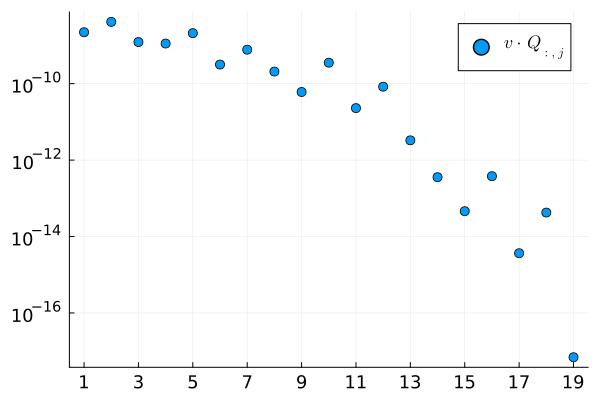

In [7]:
a = 20
x = LinRange(-1, 1, a)
A = vander(x)
Q, _ = gram_schmidt_naive(A)

v = Q[:, end]
@show norm(v)
# Note, if v is actually orthogonal, these should be 0
scatter(abs.(Q[:, 1:end-1]' * v), yscale=:log10, xticks=range(1, a-1; step=2), label="\$v \\cdot Q_{:, j}\$")

## Right-looking modified Gram-Schmidt

There are inherent data dependencies in this process.

$$
\begin{split} \Bigg[ q_1 \Bigg| q_2 \Bigg| q_3 \Bigg| q_4 \Bigg| q_5 \Bigg]
\begin{bmatrix} r_{11} & r_{12} & r_{13} & r_{14} & r_{15} \\
                       & r_{22} & r_{23} & r_{24} & r_{25} \\
                       &        & r_{33} & r_{34} & r_{35} \\
                       &        &        & r_{44} & r_{45} \\
                       &        &        &        & r_{55}
\end{bmatrix}
\end{split}
$$

In [8]:
function gram_schmidt_modified(A)
    m, n = size(A)
    Q = copy(A)
    R = zeros(n, n)
    for j in 1:n
        R[j, j]  = norm(Q[:, j])
        Q[:, j] /= R[j, j]
        R[j, j+1:end]  = Q[:, j]' * Q[:, j+1:end]
        Q[:, j+1:end] -= Q[:, j]  * R[j, j+1:end]'
    end
    Q, R
end

gram_schmidt_modified (generic function with 1 method)

In [9]:
m = 20
x = LinRange(-1, 1, m)
A = vander(x, m)
Q, R = gram_schmidt_modified(A)

# We've repaired our norms here to look like the naive variant
@show norm(Q' * Q - I)
@show norm(Q * R - A)

norm(Q' * Q - I) = 8.486718528276085e-9
norm(Q * R - A) = 7.366192855671664e-16


7.366192855671664e-16

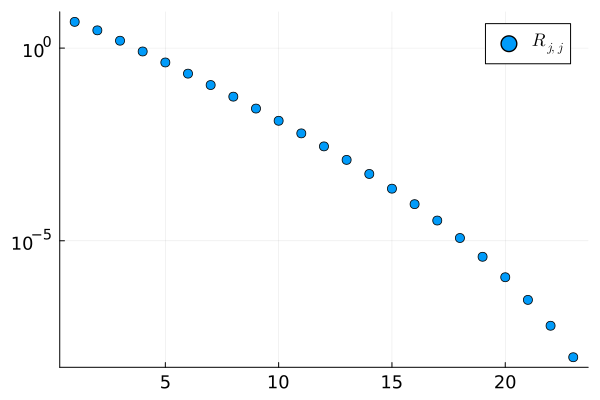

In [10]:
x = LinRange(-1, 1, 23)
A = vander(x)
# Now with modified Gram-Schmidt
Q, R = gram_schmidt_modified(A)

scatter(diag(R), yscale=:log10, label="\$R_{j, j}\$")

norm(v) = 0.9999999999999999


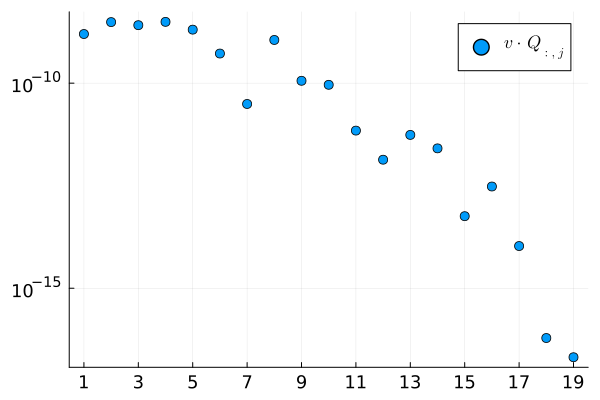

In [11]:
a = 20
x = LinRange(-1, 1, a)
A = vander(x)
Q, _ = gram_schmidt_modified(A)

v = Q[:, end]
@show norm(v)
# Note, if v is actually orthogonal, these should be 0
scatter(abs.(Q[:, 1:end-1]' * v), yscale=:log10, xticks=range(1, a-1; step=2), label="\$v \\cdot Q_{:, j}\$")

## Classical vs modified

Classical

* Really unstable, orthogonality error size of $1 \gg \epsilon_\text{machine}$

* Don't need to know all the vectors in advance

Modified

* Needs to be right-looking for efficiency

* Less unstable, but orthogonality error $10^{-9} \gg \epsilon_\text{machine}$

## Native Julia implementation

Note that Julia's implementation has further improvements.

In [12]:
m = 10
x = LinRange(-1, 1, m)
A = vander(x, m)
Q, R = qr(A)

@show norm(Q' * Q - I)
@show norm(Q * R - A);

norm(Q' * Q - I) = 1.739065259552395e-15
norm(Q * R - A) = 2.8660440008834812e-15


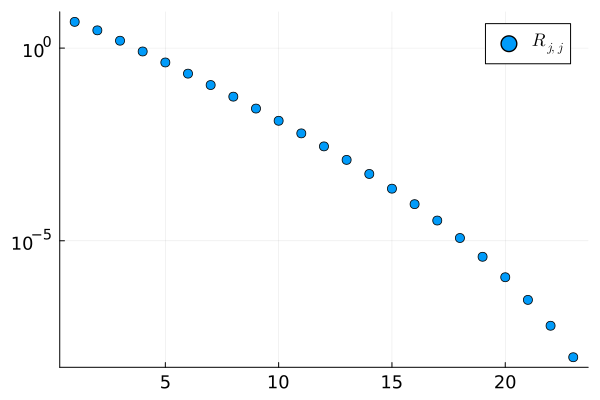

In [13]:
x = LinRange(-1, 1, 23)
A = vander(x)
# Now with modified Gram-Schmidt
Q, R = qr(A)

scatter(abs.(diag(R)), yscale=:log10, label="\$R_{j, j}\$")

norm(v) = 0.9999999999999999


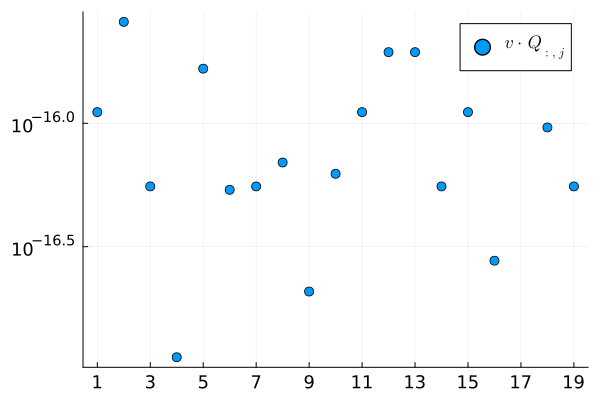

In [14]:
a = 20
x = LinRange(-1, 1, a)
A = vander(x)
Q, _ = qr(A)

v = Q[:, end]
@show norm(v)
# Note, if v is actually orthogonal, these should be 0
scatter(abs.(Q[:, 1:end-1]' * v), yscale=:log10, xticks=range(1, a-1; step=2), label="\$v \\cdot Q_{:, j}\$")